In [9]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as skpp
PATH = "rijs_2011_all.csv"
all_data = pd.read_csv(PATH, encoding="utf-8")
# all_data_norm = (all_data - all_data.mean()) - all_data.std()
all_data

,target_gene,which_CS,carbon_source_uptake,growth_rate,acetate_secretion,pts,zwf,gnd,pgi,"edd, eda",...,"glta, can",icd,suc,"sdh, fum",mdh,mae,pck,pcc,"pta, acka","acea, aceb"
0,WT,gal,2.00,0.18,0.11,2.10,0.61,0.35,1.48,0.26,...,1.48,0.53,0.23,1.18,2.09,0.04,0.74,0.45,0.11,0.95
1,AlsR,gal,2.26,0.19,0.03,2.12,0.57,0.37,1.54,0.20,...,1.40,0.32,0.00,1.09,2.18,0.00,0.92,0.49,0.03,1.09
2,AppY,gal,2.64,0.18,0.15,1.94,0.53,0.41,1.40,0.13,...,1.36,0.27,0.00,1.10,2.16,0.04,0.90,0.39,0.15,1.10
3,ArcA,gal,2.08,0.18,0.04,2.18,0.54,0.22,1.63,0.32,...,1.94,0.91,0.64,1.67,2.67,0.03,0.82,0.38,0.04,1.03
4,ArcB,gal,2.49,0.19,0.04,2.49,0.63,0.62,1.85,0.02,...,2.18,1.20,0.90,1.88,2.67,0.20,0.74,0.58,0.04,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,RseA,glu,6.29,0.53,5.31,6.53,1.84,1.26,4.67,0.57,...,1.55,1.55,0.84,0.84,0.56,0.28,0.22,2.02,4.78,0.00
186,RseB,glu,6.22,0.54,4.51,6.69,2.08,1.28,4.59,0.80,...,1.63,1.63,0.84,0.84,0.56,0.29,0.22,2.17,4.38,0.00
187,Pgi,glu,4.01,0.32,1.51,3.77,3.61,3.09,0.15,0.52,...,0.76,0.76,0.26,0.26,0.26,0.00,0.48,1.56,1.23,0.00
188,Zwf,glu,6.35,0.44,4.62,6.28,0.75,0.60,5.51,0.15,...,1.82,1.82,1.19,1.19,1.12,0.07,0.86,2.27,5.04,0.00


In [11]:
len(set(all_data['target_gene']))

95

In [21]:
target_gene_encoder = skpp.OneHotEncoder()
which_CS_encoder = skpp.OneHotEncoder()

raw_target_gene = all_data["target_gene"].values.reshape(-1, 1)
raw_which_CS = all_data["which_CS"].values.reshape(-1, 1)

target_gene_encoder.fit(raw_target_gene)
which_CS_encoder.fit(raw_which_CS)

X_left = target_gene_encoder.transform(raw_target_gene).toarray()
X_right = which_CS_encoder.transform(raw_which_CS).toarray()

print(X_left.shape, X_right.shape)
print(X_left[0])

X = np.hstack((X_left, X_right))

# raw_X = all_data.iloc[:,:3].values
# enc.fit(raw_X)
# X = enc.transform(raw_X).toarray()

Y = all_data.iloc[:,3:].values
print(X.shape, Y.shape)

(190, 95) (190, 2)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(190, 97) (190, 25)


In [22]:
# XGBoost
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
import xgboost as xgb # must be in AMN_windows env
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, List

In [23]:
LOO_split = int(Y.shape[0])

xgb_preds = []

for i in range(5):

    # XGBoost = xgb.XGBRegressor(n_estimators=600, max_depth=2, learning_rate=0.01, objective='reg:squarederror', random_state=i)
    multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))

    xgb_pred = cvp(multioutputregressor, X, Y, cv=KFold(n_splits=10, shuffle=True, random_state=i), n_jobs = 5)
    
    xgb_preds.append(xgb_pred)

In [27]:
mean_xgb_pred = np.array(xgb_preds).mean(axis=0)
std_xgb = np.array(xgb_preds).std(axis=0)

print("Squared error between mean prediction and true fluxes", np.mean((mean_xgb_pred - Y)**2, axis=0)) # MSE between mean prediction (over 5 times 10-fold test sets) and true

print("Indepedent Q² for each: ", r2_score(Y, mean_xgb_pred, multioutput="raw_values"))

print("Average Q²: ", r2_score(Y, mean_xgb_pred, multioutput="uniform_average"))

print("Variance weighted average Q²: ", r2_score(Y, mean_xgb_pred, multioutput='variance_weighted'))

Squared error between mean prediction and true fluxes [0.00282605 0.4681196  0.68340894 0.08690143 0.03982667 0.50909281
 0.04616382 0.50370713 0.00458201 0.00392325 0.00458201 2.15765711
 1.92529705 1.13690932 1.1878335  0.33365485 0.39320763 0.33601785
 0.27322412 0.25614658 0.04723084 0.04157753 0.15165783 0.51571885
 0.06002548]
Indepedent Q² for each:  [ 0.90823146  0.9056102   0.89311719  0.86468008  0.86435202  0.84101678
  0.53009467  0.87418323  0.84776687  0.67170679  0.84776687  0.88375342
  0.88195179  0.84918524  0.81706463 -0.07727267  0.4296018   0.16920631
 -0.05120746  0.650364    0.01156617  0.48379567  0.8329794   0.90762794
  0.76818209]
Average Q²:  0.6642129792336589
Variance weighted average Q²:  0.8565696231829617


<AxesSubplot:>

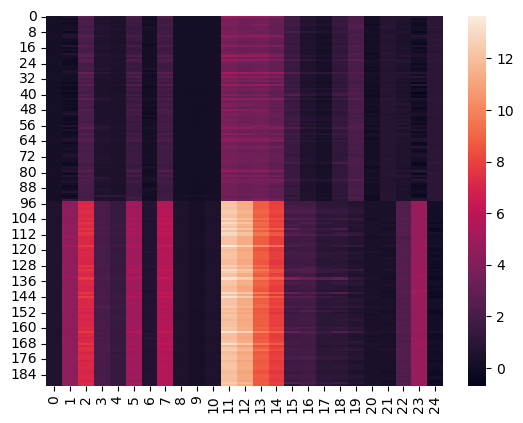

In [ ]:
sns.heatmap(mean_xgb_pred)

<AxesSubplot:>

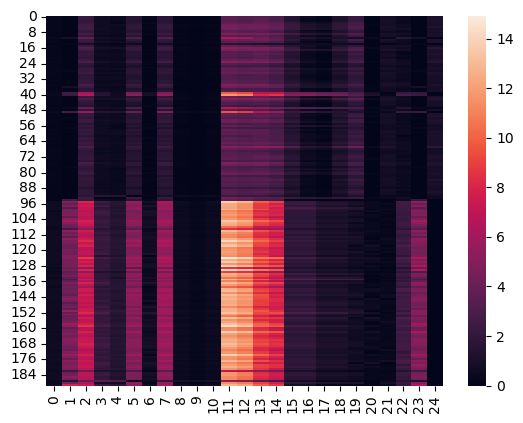

In [ ]:
sns.heatmap(Y)

c:\Users\faure\miniconda3\envs\AMN_windows\lib\site-packages\seaborn\matrix.py:859: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  z_scored = (z_scored - z_scored.mean()) / z_scored.std()


ValueError: The condensed distance matrix must contain only finite values.

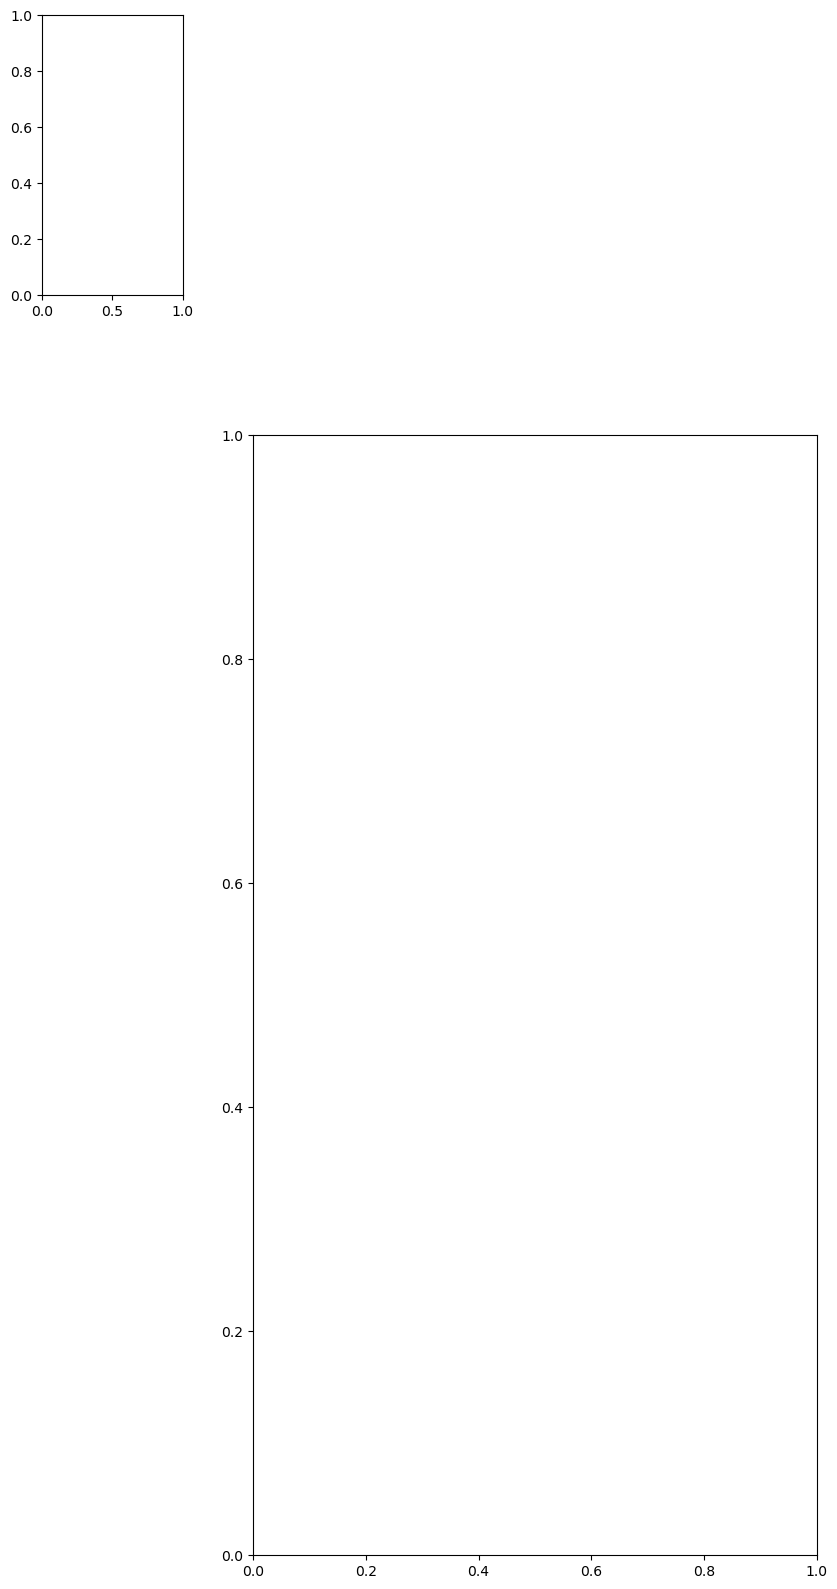

In [ ]:
plt.close('all')
clustergrid = sns.clustermap(all_data, z_score=0, figsize=(10,20), yticklabels=True)
ordered_fluxes_indices = clustergrid.dendrogram_col.reordered_ind
ordered_genes_indices = clustergrid.dendrogram_row.reordered_ind
sns.set_theme(palette="colorblind")
plt.show()

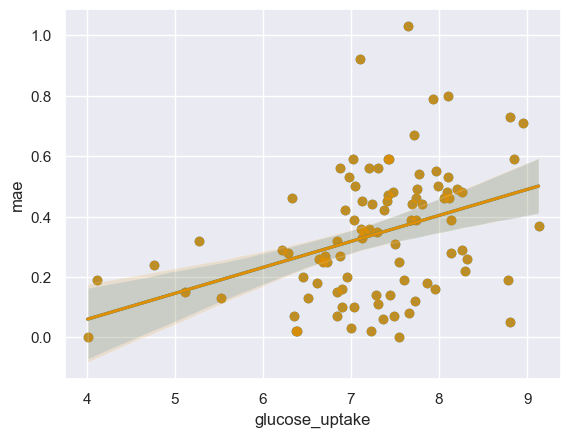

In [ ]:
sns.regplot(data=all_data, x="glucose_uptake", y="mae")
plt.show()

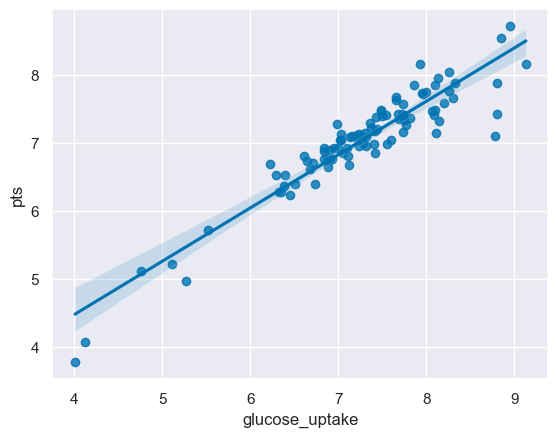

In [ ]:
sns.regplot(data=all_data, x="glucose_uptake", y="pts")
plt.show()

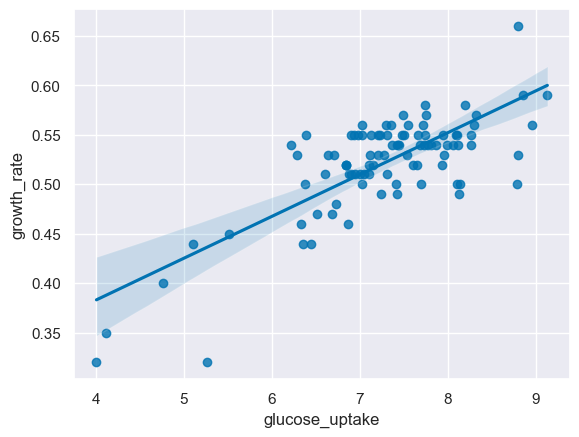

In [ ]:
sns.regplot(data=all_data, x="glucose_uptake", y="growth_rate")
plt.show()

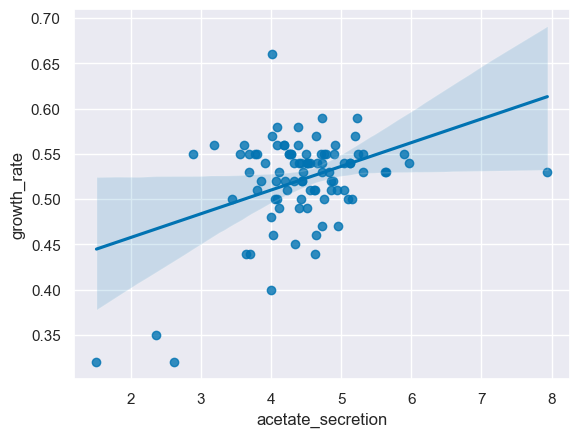

In [ ]:
sns.regplot(data=all_data, x="acetate_secretion", y="growth_rate")
plt.show()

(94, 94)


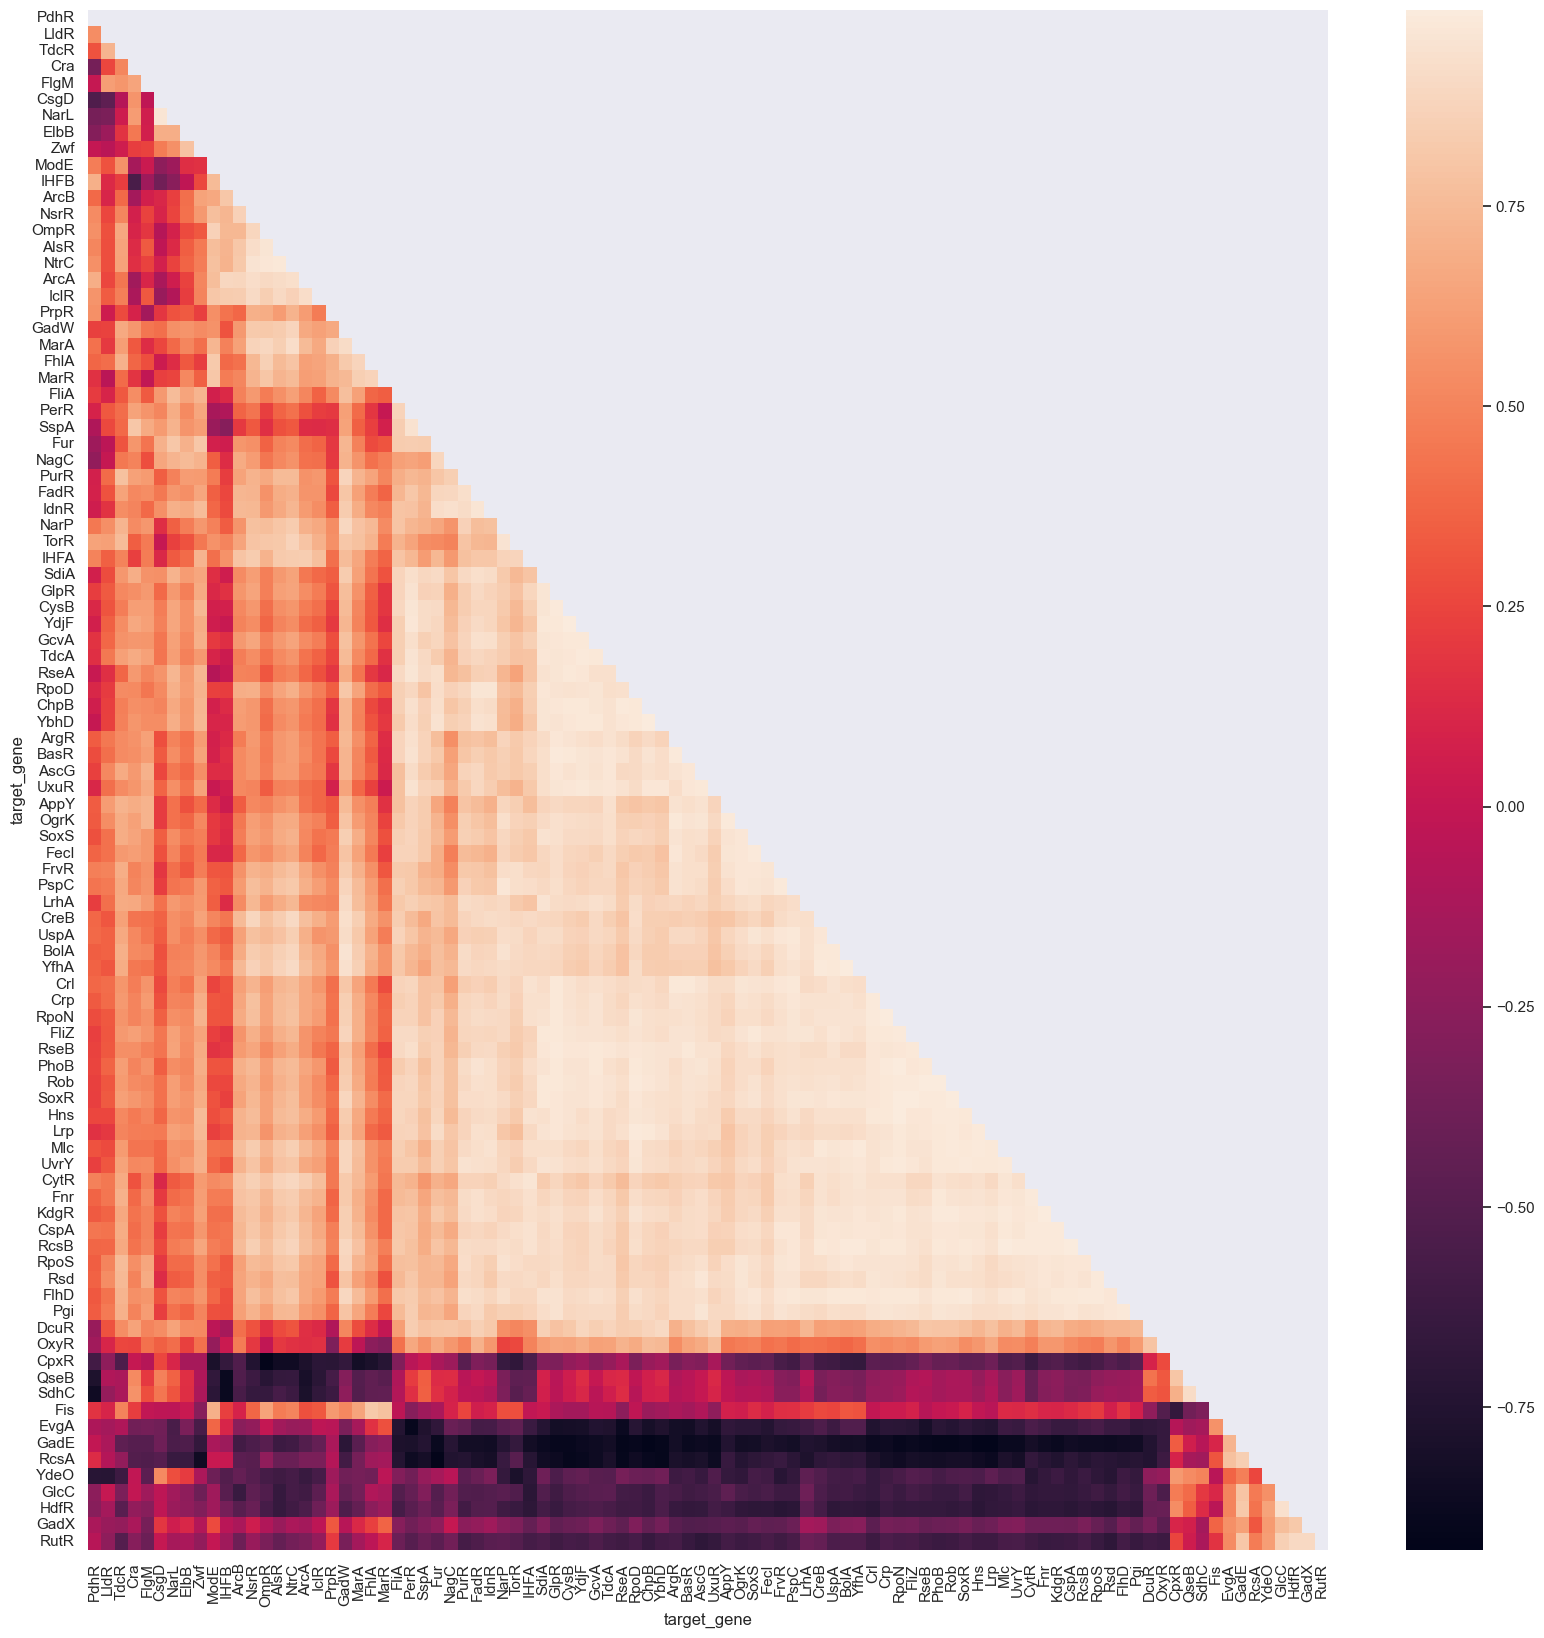

In [ ]:
corr_mat_genes = all_data_norm.iloc[ordered_genes_indices].T.corr()
mask = np.triu(np.ones_like(all_data_norm.T.corr()))
print(mask.shape)
fig, ax = plt.subplots(figsize=(20, 20))
g = sns.heatmap(corr_mat_genes, xticklabels=all_data_norm.index[ordered_genes_indices], yticklabels=all_data_norm.index[ordered_genes_indices], mask=mask)
sns.set_theme(palette="colorblind")
plt.show()

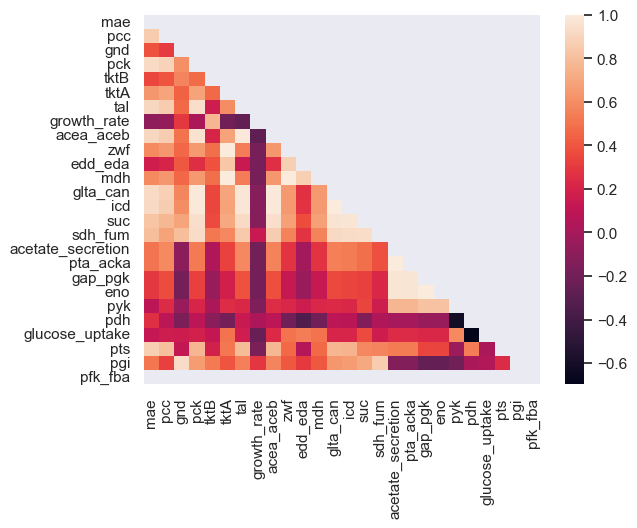

In [ ]:
plt.close('all')
corr_mat_fluxes = all_data_norm.iloc[ordered_fluxes_indices].corr()
mask = np.triu(np.ones_like(corr_mat_fluxes))
sns.heatmap(corr_mat_fluxes, xticklabels=all_data.columns[ordered_fluxes_indices], yticklabels=all_data.columns[ordered_fluxes_indices], mask=mask)
sns.set_theme(palette="colorblind")
plt.show()